# Trabalho Prático I

## 1. Objetivo

O objetivo deste trabalho prático é de praticar os conceitos aprendidos na disciplina e de adquirir
experiência no uso de alguns dos principais métodos de classificação, na avaliação de modelos e na
interpretação e apresentação de resultados de experimentos. Para isso serão utilizados e comparados métodos de classificação baseados em diferentes princípios para um prolema de classificação binária.

Serão aplicados seis métodos de classificação:
- Naive Bayes;
- Decision Tree;
- k-Nearest Neighbors;
- Support Vector Machines (SVM);
- Random Forest, e
- Gradient Tree Boosting.

## 2. Base de Dados

Os dados a serem utilizados foram fornecidos pelo professor e constituem uma base referente à classificação de candidatos a exoplanetas encontrados pela sonda espacial Kepler da NASA, sendo um exoplaneta um planeta fora do sistema solar. A sonda primeiro identifica sinais de possíveis exoplanetas, chamados de Kepler Object of Interest (KOI). Porem nem todos os KOIs são de fato exoplanetas, alguns se tratam de falsos positivos de origens diversas. 

Sendo assim, a tarefa consiste em classificar os KOIs entre exoplanetas confirmados e falsos positivos. Na base utilizada, observação corresponde a um KOI e as features são características estimadas de cada (possível) exoplaneta (tamanho, temperatura, features da estrela hospedeira, etc).

A seguir, os 5 primeiros casos da base de dados são apresentados após o carregamento de todos os módulos que serão utilizados ao longo do trabalho.

In [1]:
## Carregando os pacotes a serem utilizados.
import pandas as pd                    #para mainpulação de dataframes e leitura dos dados.
import numpy as np                     #para operações numéricas e com vetores.
import matplotlib.pyplot as plt        #para plots rápidos e simples.
from sklearn import svm                #métodos de classificação que serão utilizados.
from sklearn import metrics
from sklearn import ensemble
from sklearn import neighbors
from sklearn import feature_selection
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix  
from sklearn.model_selection import KFold
# Display plots no próprio notebook
%matplotlib inline                    
plt.style.use('ggplot')                # Utilizar estilo do ggplot'b

In [2]:
np.random.seed(10) # Setando semente para que a parte randômica o código seja reproduzida sempre igual!

# Carregando os dados (devem estar no mesmo diretório do notebook para que funcione!)
df = pd.read_csv('./koi_data.csv')

# Print das 5 primeiras linhas do dataframe.
df.head()

,kepoi_name,koi_disposition,koi_period,koi_impact,koi_duration,koi_depth,koi_ror,koi_srho,koi_prad,koi_sma,...,koi_fwm_srao,koi_fwm_sdeco,koi_fwm_prao,koi_fwm_pdeco,koi_dicco_mra,koi_dicco_mdec,koi_dicco_msky,koi_dikco_mra,koi_dikco_mdec,koi_dikco_msky
0,K00752.01,CONFIRMED,9.48804,0.146,2.95750,615.8,0.02234,3.20796,2.26,0.0853,...,0.430,0.940,-0.00020,-0.00055,-0.010,0.200,0.200,0.080,0.310,0.320
1,K00752.02,CONFIRMED,54.41838,0.586,4.50700,874.8,0.02795,3.02368,2.83,0.2734,...,-0.630,1.230,0.00066,-0.00105,0.390,0.000,0.390,0.490,0.120,0.500
2,K00754.01,FALSE POSITIVE,1.73695,1.276,2.40641,8079.2,0.38739,0.22080,33.46,0.0267,...,-0.111,0.002,0.00302,-0.00142,-0.249,0.147,0.289,-0.257,0.099,0.276
3,K00755.01,CONFIRMED,2.52559,0.701,1.65450,603.3,0.02406,1.98635,2.75,0.0374,...,-0.010,0.230,0.00008,-0.00007,0.030,-0.090,0.100,0.070,0.020,0.070
4,K00114.01,FALSE POSITIVE,7.36179,1.169,5.02200,233.7,0.18339,0.00485,39.21,0.0820,...,-13.450,24.090,0.00303,-0.00555,-4.506,7.710,8.930,-4.537,7.713,8.948


Como para esse trabalho a base de dados foi dita como conferida, não serão realizadas análises exploratórias descritivas profundas. No entanto, ressalta-se que a variável binária para a qual os modelos serão ajustados é chamada de `koi_disposition` e apresenta duas classes: <font color='red'>'CONFIRMED'</font> e <font color='red'>'FALSE POSITIVE'</font>.

In [3]:
# Calculando a porcentagem de cada caso para a variável resposta.
p_confirmed = len(df[df['koi_disposition'] == 'CONFIRMED'])/len(df) ## Percentual de 'CONFIRMED'
p_false =  len(df[df['koi_disposition'] == 'FALSE POSITIVE'])/len(df) ## Percentual de 'FALSE POSITIVE'

# Printando os valores
print('CONFIRMED:', p_confirmed) 
print('FALSE POSITIVE:', p_false)

CONFIRMED: 0.4044598231449443
FALSE POSITIVE: 0.5955401768550558


Calculando as proporções das classes que compõem a variável de interesse, notamos que se trata de um problema relativamente balanceado, de proporção aproximada de 60/40, com mais casos da categoria 'FALSE POSITIVE'.

A seguir, são apresentados os valores relativos à média, desvio-padrão e quartis para as variáveis (features) numéricas. Nota-se que 41 das features são numéricas, e como temos um total de 43 colunas, apenas as 2 primeiras são categóricas.

In [4]:
# Algumas estatísticas das variáveis numéricas
df.describe()

,koi_period,koi_impact,koi_duration,koi_depth,koi_ror,koi_srho,koi_prad,koi_sma,koi_incl,koi_teq,...,koi_fwm_srao,koi_fwm_sdeco,koi_fwm_prao,koi_fwm_pdeco,koi_dicco_mra,koi_dicco_mdec,koi_dicco_msky,koi_dikco_mra,koi_dikco_mdec,koi_dikco_msky
count,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000,...,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000
mean,37.032237,0.717106,5.607025,21340.318993,0.235205,3.415370,112.230798,0.158146,81.181413,1143.721069,...,-0.355681,-0.805629,-0.000263,0.000439,-0.049743,-0.087413,1.930251,-0.038402,-0.098738,1.920226
std,88.417985,2.628207,6.962634,66989.808550,2.586213,25.131368,3699.799318,0.241792,16.308839,775.788868,...,10.978677,14.741473,0.065707,0.077519,2.465670,2.746534,3.147553,2.465094,2.734732,3.142764
min,0.306940,0.000000,0.104600,0.800000,0.001290,0.000040,0.080000,0.007200,2.290000,92.000000,...,-275.600000,-397.620000,-4.000000,-0.800000,-21.500000,-75.900000,0.000000,-23.600000,-76.600000,0.000000
25%,2.213962,0.226000,2.500250,176.800000,0.013058,0.176092,1.460000,0.033000,81.930000,615.250000,...,-0.500000,-0.570000,-0.000240,-0.000240,-0.270000,-0.291500,0.128250,-0.265250,-0.320000,0.180000
50%,7.386755,0.610000,3.805500,495.950000,0.024185,0.748045,2.600000,0.073650,87.890000,948.000000,...,0.000000,-0.030000,0.000000,0.000000,0.000000,0.000000,0.460000,-0.007000,-0.018000,0.453000
75%,23.448117,0.923750,6.000750,2120.525000,0.171260,2.267063,21.645000,0.158200,89.520000,1482.000000,...,0.500000,0.450000,0.000260,0.000280,0.230000,0.230000,2.570000,0.226250,0.250000,2.420000
max,1071.232620,100.806000,138.540000,864260.000000,99.870650,918.752390,200346.000000,2.034500,90.000000,9791.000000,...,97.780000,98.780000,1.190000,5.000000,45.680000,27.500000,88.600000,46.570000,31.200000,89.600000


Como a primeira coluna do dataframe constitui à identificação de cada objeto, essa será removida do dataframe. 

In [5]:
# Alterando index (rodar apenas uma vez, se rodar duas retornará erro)
df = df.drop('kepoi_name', axis=1)
df.head()

,koi_disposition,koi_period,koi_impact,koi_duration,koi_depth,koi_ror,koi_srho,koi_prad,koi_sma,koi_incl,...,koi_fwm_srao,koi_fwm_sdeco,koi_fwm_prao,koi_fwm_pdeco,koi_dicco_mra,koi_dicco_mdec,koi_dicco_msky,koi_dikco_mra,koi_dikco_mdec,koi_dikco_msky
0,CONFIRMED,9.48804,0.146,2.95750,615.8,0.02234,3.20796,2.26,0.0853,89.66,...,0.430,0.940,-0.00020,-0.00055,-0.010,0.200,0.200,0.080,0.310,0.320
1,CONFIRMED,54.41838,0.586,4.50700,874.8,0.02795,3.02368,2.83,0.2734,89.57,...,-0.630,1.230,0.00066,-0.00105,0.390,0.000,0.390,0.490,0.120,0.500
2,FALSE POSITIVE,1.73695,1.276,2.40641,8079.2,0.38739,0.22080,33.46,0.0267,67.09,...,-0.111,0.002,0.00302,-0.00142,-0.249,0.147,0.289,-0.257,0.099,0.276
3,CONFIRMED,2.52559,0.701,1.65450,603.3,0.02406,1.98635,2.75,0.0374,85.41,...,-0.010,0.230,0.00008,-0.00007,0.030,-0.090,0.100,0.070,0.020,0.070
4,FALSE POSITIVE,7.36179,1.169,5.02200,233.7,0.18339,0.00485,39.21,0.0820,60.92,...,-13.450,24.090,0.00303,-0.00555,-4.506,7.710,8.930,-4.537,7.713,8.948


Por fim, transformaremos a variável de interesse de forma que os falsos positivos serão 0 e os exoplanetas verdadeiros serão 1.

In [6]:
# Cria-se um for para analisar cada caso da variável 'koi_disposition'. Se for 'CONFIRMED' atribuímos 1, caso contrátrio 0.
result = []
for i in range(len(df)):
    if df['koi_disposition'][i] == 'CONFIRMED':
        result.append(1)
    else:
        result.append(0)
        
# Em seguida substituímos os valores no dataframe
df['koi_disposition'] = result

## 3. Métodos

Nessa seção será apresentado o desenvolvimento de todos os métodos a serem aplicados, em subseções, bem como uma breve descrição de cada algoritmo. Para cada algortimo, primeiro selecionaremos os melhores parâmetro por cross-validation e após realizarmos isso para todos os modelos, iremos comparar os modelos selecionados no fim desse trabalho.

### 3.1 Naive Bayes

O Naive Bayes consiste em um algoritmo com uma abordagem probabilística para problemas de classificação. Podemos descrever o algoritmo em 2 etapas:

- Estima-se a distribuição de probabilidade a partir dos dados observados;
- Para um determinado conjunto de features $X$, estima-se sua classe com base em $\hat{y} = argmax(p_\theta(y|X))$.

Como podemos notar pelos passos do algoritmo, para estimar a probabilidade de pertencimento a uma dada classe é necessário saber todas as combinações das features. Para um problema com muitas features, ou no caso em que uma determinada feature $x_i$ possa assumir muitos valores, isso torna-se caro computacionalmente.

Para contornar tal problema, utiliza-se o Teorema de Bayes, que relaciona uma probabilidade condicional conforme apresentado na equação a seguir:

$$p(y|X) = \frac{p(y)p(X|y)}{p(X)}.$$

Assim, reformula-se o problema de maneira a deixá-lo mais viável para se encontrar uma solução para cada caso. Como ônus, têm-se a suposição de independência condicional, isto é, os valores de uma feature $x_i$ devem ser independentes dos valores das demais. Caso contrário, tem-se um problema de multicolinearidade, muito estudado em regressão linear.

Aqui, será aplicado um experimento com base no Naive Bayes como baseline para o estudo do problema. Como utilizaremos a função GaussianNB do pacote sklearn, primeiramente iremos normalizar as variáveis do nosso dataframe, com exceção da variável de interesse.

In [7]:
# Definindo a função de normalização
def normalization(x):
    xn = (x-x.mean())/x.std()
    return xn

# Aplicando a normalização aos dados
df_n = normalization(df.iloc[:,1:])

# Adicionando a variável resposta
df_n = pd.DataFrame(pd.concat([df['koi_disposition'], df_n], axis=1))

df_n.head()

,koi_disposition,koi_period,koi_impact,koi_duration,koi_depth,koi_ror,koi_srho,koi_prad,koi_sma,koi_incl,...,koi_fwm_srao,koi_fwm_sdeco,koi_fwm_prao,koi_fwm_pdeco,koi_dicco_mra,koi_dicco_mdec,koi_dicco_msky,koi_dikco_mra,koi_dikco_mdec,koi_dikco_msky
0,1,-0.311523,-0.217299,-0.380535,-0.309368,-0.082308,-0.008253,-0.029723,-0.301276,0.519877,...,0.071564,0.118416,0.000962,-0.012755,0.016119,0.104646,-0.549713,0.048032,0.149462,-0.509178
1,1,0.196636,-0.049884,-0.157990,-0.305502,-0.080138,-0.015586,-0.029569,0.476664,0.514358,...,-0.024986,0.138089,0.014050,-0.019205,0.178346,0.031827,-0.489349,0.214354,0.079985,-0.451904
2,0,-0.399187,0.212652,-0.459685,-0.197957,0.058845,-0.127115,-0.021291,-0.543633,-0.864035,...,0.022287,0.054786,0.049967,-0.023978,-0.080812,0.085349,-0.521437,-0.088677,0.072306,-0.523178
3,1,-0.390267,-0.006128,-0.567677,-0.309555,-0.081642,-0.056862,-0.029591,-0.499380,0.259282,...,0.031487,0.070253,0.005223,-0.006563,0.032341,-0.000942,-0.581484,0.043975,0.043418,-0.588726
4,0,-0.335570,0.171940,-0.084024,-0.315072,-0.020035,-0.135708,-0.019736,-0.314924,-1.242358,...,-1.192705,1.688816,0.050119,-0.077256,-1.807321,2.839001,2.223870,-1.824919,2.856491,2.236176


Após aplicarmos a função `normalization` definida, todas as variáveis seguem uma distrição normal padrão, isso é, possuem média 0 e desvio-padrão 1. Sendo assim, prosseguimos para o segundo passo antes de implementar o algoritmo, a separação em treino e teste. Como possuímos um número relativamente grande de observações, utilizaremos 60% da base de dados como treinamento e 40% como teste.

In [8]:
# Separando em treino e teste
idx = list(df_n.index)                            # lista os indexes
np.random.shuffle(idx)                            # embaralha os index
train, test = df_n[:int(0.6*len(idx))], df_n[int(0.6*len(idx)):]              # seleciona os 60% e os 40%. (NORMALIZADO)

# Separando em y e X com normalização
train_x, train_y = train.iloc[:,1:], train['koi_disposition']
test_x, test_y = test.iloc[:,1:], test['koi_disposition']

In [9]:
from sklearn.naive_bayes import GaussianNB

# Criando um classificador gaussiano
model_nb = GaussianNB()

# Treinando o modelo
model_nb.fit(train_x, train_y)

# Predict Output
y_pred_test = model_nb.predict(test_x)
y_pred_train = model_nb.predict(train_x)

In [10]:
# Calculando a acurácia, precisão e recall
print('Acurácia Train:', metrics.accuracy_score(train_y, y_pred_train))
print('Acurácia Test:', metrics.accuracy_score(test_y, y_pred_test))
print('Precision:', metrics.precision_score(test_y, y_pred_test))
print('Recall:', metrics.recall_score(test_y, y_pred_test))

Acurácia Train: 0.938481256008
Acurácia Test: 0.910139356079
Precision: 0.425170068027
Recall: 0.874125874126


### 3.2 Decision Tree

Árvores de decisão são métodos de aprendizado supervisionado não-paramétrico, utilizados em tarefas de classificação e regressão. Pestana and Gageiro (2009) mostram que este método utiliza de regras de decisão simples, inferidas a partir dos dados, para prever o valor de uma variável alvo. Tais decisões geram divisões sucessivas a partir de características dos dados (fetures).

Árvores de decisão são modelos que possuem como vantagens a simples interpretação e visualização dos resultados, sendo possível esquematizá-los de forma similar a uma árvore genealógica. Para sua separação, leva-se em conta os conceitos de entropia e pureza, esse último, aplicado no amplamente utilizado índice de Gini.

Para escolher o tamanho (profundidade) ideal do modelo (relacionado ao número de divisões das features, ou nós da árvore) é comum a aplicação de um método chamado cross-validation. De fato, esse método é amplamente utilizado para seleção de parâmetros em diversos modelos da área de *machine learning*. Por isso, o mesmo será descrito a seguir e é utilizado durante todo o trabalho, a partir desse ponto.

#### k-Fold Cross-Validation

O processo de validação cruzada, ou cross-validation, têm como aplicação o auxílio na escolha de parâmetros de cada modelo.
Seu funcionamento ocorre da seguinte maneira:
1. Embaralha-se o banco de dados de forma aleatória, just in case.

2. Separa-se o banco de dados em $k$ grupos.

3. Para cada grupo:
   
   i) Seleciona-se um grupo para teste.
   
   ii) Seleciona-se o restante como dados de treino.
   
   iii) Ajusta-se um modelo sob o treino e avalie no teste.
   
   iv) Mantém-se a avaliação (nesse caso, a acurácia) e o parâmetro correspondente e descarta-se o modelo.
   
4. Replica-se o passo 3 para todos os grupos e compara-se todas a média das acurácias e seleciona-se o parâmetro que levou àquele resultado. 
5. Checa-se por *overfitting* e caso ocorra, excluímos essa possibilidade e repete-se o a partir do passo 4. Caso contrário, opta-se pelo modelo referente àquele parâmetro selecionado.

**Nesse trabalho, consideraremos *overfitting* os modelos em que tivermos grande acurácia média nos bancos de treino após a cross-validation e uma diferença maior que 4% da acurácia média nos bancos de teste.**

Quanto à sepração do banco, utilizaremos o banco com os valores não normalizados, visto que alguns estudos demonstraram que para esse tipo de algoritmo a normalização nem sempre afeta de maneira positiva o resultado. Ressalta-se que os experimentos foram realizados com os dados normalizados, e os resultados não desviaram positivamente dos encontrados com os dados em seus valores originais.

A seguir ajustamos uma árvore de decisão e aplicamos o procedimento de cross-validation para os valores relativos à profundidade de cada árvore. Tais valores foram variados de 3 a 40, dado que nesse problema, temos apenas 41 features.

In [11]:
# Bibliotecas para DT
from sklearn.tree import DecisionTreeClassifier

In [12]:
# Separação do banco.
X = df.iloc[:,1:]
y = df.iloc[:,0]

In [13]:
# Criando os k grupos que irão receber os dados
cv = KFold(n_splits=5, random_state=1, shuffle=False)

# Cria-se uma lista com os valores para o parâmetro que queremos variar.
sizes = list(range(3, 40))

# Duas listas vazias para receberem o valores médios da acurácia para cada variação do valor do parâmetro.
acc_test_mean = []
acc_train_mean = []
acc_test_sd = []
acc_train_sd = []
# Início de loop variando o parâmetro de interesse 
for depth in sizes:
    acc_test = []
    acc_train = []
    for train_index, test_index in cv.split(X):
        # Separando em treino e teste
        X_train, X_test, y_train, y_test = X.loc[train_index], X.loc[test_index], y.loc[train_index], y.loc[test_index]

        # Criando objeto para k-NN
        model_dt = DecisionTreeClassifier(max_depth=depth)

        # Treinando o modelo
        model_dt.fit(X_train, y_train.values.ravel())

        # Fazendo previsões
        y_pred_test = model_dt.predict(X_test)
        y_pred_train = model_dt.predict(X_train)
        
        # Calculando a acurácia para os bancos de treino e teste
        acc_test.append(metrics.accuracy_score(y_test, y_pred_test))
        acc_train.append(metrics.accuracy_score(y_train, y_pred_train))
        
    # Calculando a média e desvio padrão da acurácia
    acc_test_mean.append(np.array(acc_test).mean())
    acc_train_mean.append(np.array(acc_train).mean())
    acc_test_sd.append(np.array(acc_test).std())
    acc_train_sd.append(np.array(acc_train).std())

Também ajustamos um modelo para quando não se restringe a profundidade da árvore. Os resultados para esse modelo foram acoplados ao dataframe dos demais resultados de modelos e é referenciado no último index.

In [14]:
for train_index, test_index in cv.split(X):
        # Separando em treino e teste
        X_train, X_test, y_train, y_test = X.loc[train_index], X.loc[test_index], y.loc[train_index], y.loc[test_index]

        # Criando objeto para árvore de decisão
        model_dt = DecisionTreeClassifier(max_depth=None)

        # Treinando o modelo
        model_dt.fit(X_train, y_train)

        # Fazendo previsões
        y_pred_test = model_dt.predict(X_test)
        y_pred_train = model_dt.predict(X_train)
        
        # Calculando a acurácia para os bancos de treino e teste
        acc_test.append(metrics.accuracy_score(y_test, y_pred_test))
        acc_train.append(metrics.accuracy_score(y_train, y_pred_train))

# Calculando a média e desvio padrão das acurácias
acc_test_mean.append(np.array(acc_test).mean())
acc_train_mean.append(np.array(acc_train).mean())
acc_test_sd.append(np.array(acc_test).std())
acc_train_sd.append(np.array(acc_train).std())

In [15]:
# Adicionando o modelo com não limitação da profundidade da aŕvore como index 40.
sizes.append(40)

In [16]:
# Transformamos as listas com os resultados em dataframes e selecionamos como indexes o parâmetro variado nos procedimento recursivos anteriores.
mean_test_dt = pd.DataFrame(acc_test_mean, index=sizes, columns=['acc_mean_test'])
mean_train_dt = pd.DataFrame(acc_train_mean, index=sizes, columns=['acc_mean_train'])
sd_train_dt = pd.DataFrame(acc_train_sd, index=sizes, columns=['sd_mean_train'])
sd_test_dt = pd.DataFrame(acc_test_sd, index=sizes, columns=['sd_mean_test'])

In [17]:
# Concatena e cria um dataframe com os resultados
results_dt = pd.DataFrame(pd.concat([mean_train_dt, mean_test_dt,
                                     sd_train_dt, sd_test_dt], axis=1))

# Calculando as diferenças
results_dt['Dif'] = results_dt['acc_mean_train'] - results_dt['acc_mean_test']

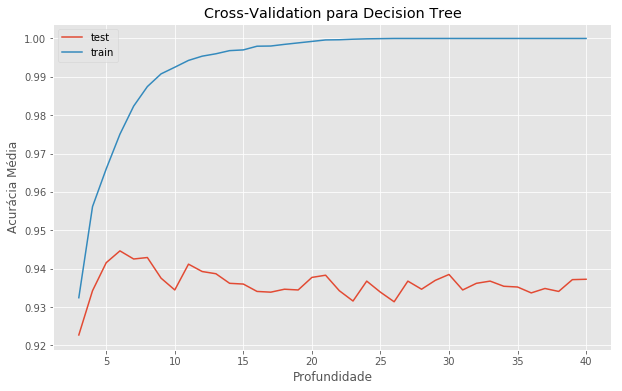

In [18]:
# Utilizamos as funções da biblioteca matplotlib para plotar os resultados e definir o melhor modelo
plt.figure(figsize=(10,6))
plt.xlabel('Profundidade')
plt.ylabel('Acurácia Média')
plt.title('Cross-Validation para Decision Tree')
plt.plot(mean_test_dt, label='test')
plt.plot(mean_train_dt, label='train')
plt.legend()

In [19]:
# Reordenando para se encontrar o melhor resultado
results_dt = results_dt.sort_values(by=['acc_mean_test', 'acc_mean_train'], ascending=False)
results_dt = results_dt.sort_values(by=['Dif'], ascending=True) # Rodou-se esse chunck com essa linha comentada para comparação!

#Visualizando os 5 primeiros
results_dt.head()

,acc_mean_train,acc_mean_test,sd_mean_train,sd_mean_test,Dif
3,0.932429,0.922717,0.007460,0.018913,0.009712
4,0.956171,0.934253,0.002512,0.013248,0.021918
5,0.966023,0.941561,0.002836,0.004180,0.024462
6,0.975058,0.944637,0.003290,0.007002,0.030421
7,0.982363,0.942520,0.001902,0.005336,0.039843


No gráfico a cima, pode-se notar que a medida que aumentamos a profundidade máxima da árvore, o modelo tende a ter melhor desempenho nos dados de treino, em contrariedade com o desempenho nos dados de teste. Isso se deve ao fato de que ao aumentarmos o númerode divisões sucessivas realizadas em nossa árvore de decisão, aumenta-se a complexidade do modelo, o que nos leva a ter um erro por variância maior, e consequente *overfit*. 


Sendo assim, devemos escolher como melhor modelo aquele com melhor desempenho no banco de teste dentre os que possuem diferença entre as acurácias menor ou igual a 4% (definido previamente nesse relatório). Graficamente, seria o ponto em que as curvas "descolam" uma da outra, em que descolar seria ter uma diferença exatamente igual a 0.04.

#### Notamos que o ponto mais próximo desse comportamento é aquele referente ao modelo em que a profundidade máxima é 6. Esse será o modelo utilizado na parte final desse trabalho de comparação com os demais modelos selecionados.

### 3.3 SVM

Uma máquina de vetores suportes (support vector machine), conforme definido por Cortes and Vapnik (1995), consiste em um método de aprendizado supervisionado, que a partir da análise de dados, reconhece padrões e classifica cada entrada de acordo com suas características de forma não probabilística. Neste método, a ideia consiste em encontrar um vetor que melhor separe duas classes.

Para a realização da classificação é comum utilizarmos os valores da variável resposta
binária em -1,1 ao invés de 0,1. Sendo assim, calcula-se:

$$f(x) = \beta_0 + \beta_1x_1 + ... + \beta_px_p,$$

onde $x_i$ corresponde ao vetor referente a $i$-ésima feature e $\beta_i$ o parâmetro correspondente e a partir desta, caso $f(x) < 0$ predizemos $Y=-1$, isto é $g(x)=-1$. Caso $f(x)>0$, classificamos $Y=1$.

Por isso, a seguir iremos reformatar a variável resposta desse trabalho temporariamente para $-1$ nos casos em que originalmente tínhamos `FALSE POSITIVE` para -1. Além disso iremos utilizar os dados de maneira normalizada, para se ter menor custo computacional.

In [20]:
# Cria-se um for para analisar cada caso da variável 'koi_disposition'. Se for 1 atribuímos 1, caso contrátrio -1.
result = []
for i in range(len(df)):
    if df_n['koi_disposition'][i] == 1:
        result.append(1)
    else:
        result.append(-1)
        
# Em seguida substituímos os valores no dataframe
df_n['koi_disposition'] = result

In [21]:
# Separando features de variável de interesse (TARGET).
X = df_n.iloc[:,1:]
y = df_n.iloc[:,0]

In [22]:
# Voltando pro original após selecionar X e y
result = []
for i in range(len(df)):
    if df_n['koi_disposition'][i] == 1:
        result.append(1)
    else:
        result.append(0)
        
# Em seguida substituímos os valores no dataframe
df_n['koi_disposition'] = result

No entanto, quando se trata de duas dimensões bem separadas, a classificação acontece de forma correta com relativa facilidade. No entanto, quando as classes estão espalhadas de forma mais homogênea no espaço, um SVM linear não consegue separar os dados de forma apropriada. Para isso, utiliza-se o truque do kernel, que consiste em projetar os dados em um novo espaço aonde seja possível realizar a separação de classes por um hiperplano ou outra forma a depender da nova dimensão, e após isso retornar ao espaço original de forma que o kernel não seja mais linear e separe bem os dados.

De forma algébrica, o truque do kernel consiste na realização de transformações das variáveis originais e aplicar o classificador SVM nos dados transformados. Logo, a solução pode ser escrita como na equação a seguir:

$$f(x) = \beta_0 + \sum_{k=1}^n \alpha_kK(x,x_k),$$

onde $K(x,x_k)$ corresponde a transformação aplicada nas observações das covariáveis. 

Pode-se utilizar diversos tipos diferentes de funções kernel. Nesse trabalho, iremos testar os kernels linear, polinomial, sigmoidal e RFB. Esse será o parâmetro a ser escolhido utilizando validação cruzada dos dados. Todo o procedimento da cross-validation se assemelha ao realizado ná árvore de decisão, por isso alguns comentários serão suprimidos e o código pode ser encontrado a seguir.

In [23]:
from sklearn.svm import SVC                                  # Importando funções importantes relativas a SVM. 
cv = KFold(n_splits=5, random_state=1, shuffle=False)        # Realizamos a criação dos k grupos do nosso dado.
kernels = ['linear', 'poly', 'sigmoid', 'rbf']
acc_test_mean = []
acc_train_mean = []
acc_test_sd = []
acc_train_sd = []
for ker in kernels:
    acc_test = []
    acc_train = []
    for train_index, test_index in cv.split(X):
        # Separando em treino e teste
        X_train, X_test, y_train, y_test = X.loc[train_index], X.loc[test_index], y.loc[train_index], y.loc[test_index]

        # Criando objeto para k-NN
        model_svm = SVC(kernel=ker)

        # Treinando o modelo
        model_svm.fit(X_train, y_train)

        # Fazendo previsões
        y_pred_test = model_svm.predict(X_test)
        y_pred_train = model_svm.predict(X_train)
        
        # Calculando a acurácia, precisão e recall
        acc_test.append(metrics.accuracy_score(y_test, y_pred_test))
        acc_train.append(metrics.accuracy_score(y_train, y_pred_train))
        
    # Calculando a média e o desvio padrão das acurácias
    acc_test_mean.append(np.array(acc_test).mean())
    acc_train_mean.append(np.array(acc_train).mean())
    acc_test_sd.append(np.array(acc_test).std())
    acc_train_sd.append(np.array(acc_train).std())

In [24]:
# Criando dataframes com os resultados
mean_test_svm = pd.DataFrame(acc_test_mean, index=kernels, columns=['acc_mean_test'])
mean_train_svm = pd.DataFrame(acc_train_mean, index=kernels, columns=['acc_mean_train'])
sd_test_svm = pd.DataFrame(acc_test_sd, index=kernels, columns=['acc_sd_test'])
sd_train_svm = pd.DataFrame(acc_train_sd, index=kernels, columns=['acc_sd_rain'])

In [25]:
# Concatena e cria um dataframe com os resultados
results_svm = pd.DataFrame(pd.concat([mean_train_svm, mean_test_svm,
                                     sd_train_svm, sd_test_svm], axis=1))

# Calculando as diferenças
results_svm['Dif'] = results_svm['acc_mean_train'] - results_svm['acc_mean_test']

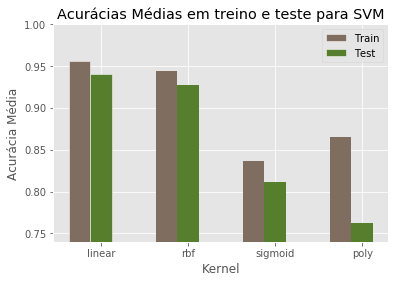

In [64]:
# Ajusta tamanho das barras
bar_width = 0.25
 
# Valores que vamos plotar
foo1 = results_svm['acc_mean_train']
foo2 = results_svm['acc_mean_test']

# Posições em que vamos plotar
r1 = np.arange(len(foo1))
r2 = [x + bar_width for x in r1]
 
# Plotando as barras
plt.bar(r1, foo1, color='#7f6d5f', width=bar_width, edgecolor='white', label='Train')
plt.bar(r2, foo2, color='#557f2d', width=bar_width, edgecolor='white', label='Test')
 
# Customizando eixo x
plt.xticks([r + bar_width for r in range(len(foo1))], results_svm.index)

# Ajustes no gráfico
plt.xlabel('Kernel')
plt.ylabel('Acurácia Média')
plt.ylim((0.74, 1))
plt.legend()
plt.title('Acurácias Médias em treino e teste para SVM')
plt.show()

In [27]:
# Reordenando para se encontrar o melhor resultado
results_svm = results_svm.sort_values(by=['acc_mean_test', 'acc_mean_train'], ascending=False)
results_svm = results_svm.sort_values(by=['Dif'], ascending=True) # Rodou-se esse chunck com essa linha comentada para comparação!

#Visualizando os 5 primeiros
results_svm.head()

,acc_mean_train,acc_mean_test,acc_sd_rain,acc_sd_test,Dif
linear,0.955738,0.941175,0.002057,0.012190,0.014563
rbf,0.944204,0.927142,0.002553,0.009533,0.017062
sigmoid,0.836649,0.812009,0.009087,0.043858,0.024640
poly,0.865244,0.762974,0.022793,0.081876,0.102270


Após a aplicação de validação cruzada para os tipos de kernel, fica clara a superioridade de desempenho do kernel Linear. Essa superioridade do kernel linear nos revela que o problema em questão nem sempre será melhor resolvido pelo modelo de maior complexidade, ou seja, evidencia o aumento do erro devido a variância. O aumento do número de vetores de suporte apresenta relação linear positiva com a complexididade no momento de teste, bem como o número de features. Além disso, aumenta-se o custo computacional, reforçando que o modelo com kernel linear é o mais adequado. Isso não significa que o kernel linear terá sempre um desempenho melhor, e sim que esse problema apresenta uma facilidade de separação suficientemente resolvível pela complexidade imposta ao se utilizar esse kernel. Para problemas mais difíceis de se separar, é provável um melhor desempenho de outros kernels.

### 3.4 k-NN

O k-NN é um algoritmo simples utilizado pra previsões baseadas em medidas de similaridade. Vem sido muito utilizado em reconhecimento de padrões e para estimações estatísticas. Basicamente, um caso é classificado de acordo com a maioria dos votos de seus k pontos mais próximos. No caso de k=1, a classe será a mesma de seu vizinho mais próximo. 

Sendo assim, o parâmetro de interesse no momento de aplicação do *cross-validation* será o número de vizinhos a se considerar. O código utilizado, é apresentado a seguir e possui a mesma estrutura dos modelos anteriores, de forma a facilitar o acompanhamento de raciocínio.

Como o número de vizinhos está relacionado ao número de observações do banco de dados, os limites de busca serão mais esparsos se comparados ao modelo de árvores de decisão.

In [65]:
from sklearn.neighbors import KNeighborsClassifier

In [66]:
X = df_n.iloc[:,1:]
y = df_n.iloc[:,0]

In [71]:
cv = KFold(n_splits=5, random_state=1, shuffle=False)
sizes = list(range(2, 30, 2))
acc_test_mean = []
acc_train_mean = []
acc_test_sd = []
acc_train_sd = []
for k in sizes:
    acc_test = []
    acc_train = []
    for train_index, test_index in cv.split(X):
        # Separando em treino e teste
        X_train, X_test, y_train, y_test = X.loc[train_index], X.loc[test_index], y.loc[train_index], y.loc[test_index]

        # Criando objeto para k-NN
        model_knn = KNeighborsClassifier(n_neighbors=k)

        # Treinando o modelo
        model_knn.fit(X_train, y_train.values.ravel())

        # Fazendo previsões
        y_pred_test = model_knn.predict(X_test)
        y_pred_train = model_knn.predict(X_train)
        
        # Calculando a acurácia, precisão e recall
        acc_test.append(metrics.accuracy_score(y_test, y_pred_test))
        acc_train.append(metrics.accuracy_score(y_train, y_pred_train))

    # Calculando a média da acurácia
    acc_test_mean.append(np.array(acc_test).mean())
    acc_train_mean.append(np.array(acc_train).mean())
    acc_test_sd.append(np.array(acc_test).std())
    acc_train_sd.append(np.array(acc_train).std())

In [72]:
# Criando dataframes com os resultados
mean_test_knn = pd.DataFrame(acc_test_mean, index=sizes, columns=['acc_mean_test'])
mean_train_knn = pd.DataFrame(acc_train_mean, index=sizes, columns=['acc_mean_train'])
sd_test_knn = pd.DataFrame(acc_test_sd, index=sizes, columns=['acc_sd_test'])
sd_train_knn = pd.DataFrame(acc_train_sd, index=sizes, columns=['acc_sd_rain'])

In [73]:
# Concatena e cria um dataframe com os resultados
results_knn = pd.DataFrame(pd.concat([mean_train_knn, mean_test_knn,
                                      sd_train_knn, sd_test_knn], axis=1))

# Calculando as diferenças
results_knn['Dif'] = results_knn['acc_mean_train'] - results_knn['acc_mean_test']

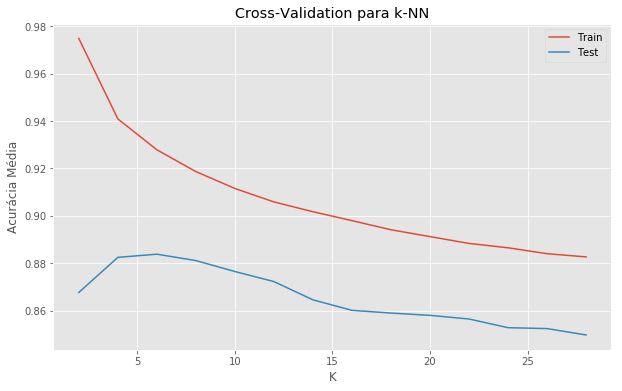

In [74]:
plt.figure(figsize=(10,6))
plt.xlabel('K')
plt.ylabel('Acurácia Média')
plt.title('Cross-Validation para k-NN')
plt.plot(results_knn['acc_mean_train'], label='Train')
plt.plot(results_knn['acc_mean_test'], label='Test')
plt.legend()

In [79]:
# Reordenando para se encontrar o melhor resultado
results_knn = results_knn.sort_values(by=['acc_mean_test', 'acc_mean_train'], ascending=False)
#results_knn = results_knn.sort_values(by=['Dif'], ascending=True) # Rodou-se esse chunck com essa linha comentada para comparação!

#Visualizando os 5 primeiros
results_knn.head()

,acc_mean_train,acc_mean_test,acc_sd_rain,acc_sd_test,Dif
6,0.927865,0.883882,0.003353,0.027502,0.043982
4,0.940888,0.882542,0.001568,0.014384,0.058347
8,0.918685,0.881187,0.002973,0.035427,0.037498
10,0.911573,0.876573,0.002659,0.036903,0.035000
12,0.905902,0.872341,0.003594,0.043887,0.033561


Primeiramente, nota-se o maior tempo computacional para execução do algoritmo. Isso se deve ao fato de ser necessário o cálculo da distância de todos os pontos existentes para o funcionamento desse método.

Além disso, nota-se que, para o caso em estudo, o k-NN com melhor desempenho pode ser dado por aquele que considera os 6 primeiros vizinhos, ou seja, k=6.

### 3.5 Random Forest

Conforme apresentado por Breiman (2001), floresta aleatória é um método de machine learning que também pode ser utilizado para classificação ou regressão. Como o próprio nome sugere, este método estima várias árvores de decisão e combina seus preditores de forma a minimizar o risco. Pode ser provado por através de contas estatísticas que se tomarmos a média de dois preditores, g1(x) e g2(x), não correlacionados, independentes e com mesma variância, o preditor obtido apresenta menor risco esperado do que g1(x) e g2(x).

Nos modelos apresentados até o momento, utlizamos apenas um função de risco, enquanto neste caso, contruíremos B árvores de decisão, cada uma com sua função de risco e as combinaremos para criar um estimador com menor variância. O procedimento computacional de uma floresta aleatória pode ser descrito como:

a. Criamos B amostras bootstrap, isto é, com reposição, da amostra original com m
covariáveis, selecionadas aleatoriamente, sendo que m < p.

b. Para cada amostra, constrói-se uma árvore de decisão e calcula-se sua função de predição $g^b(x)$.

c. Estimamos o preditor final utilizando a moda dos $g^b(x)$.


A ideia por trás da utilização de apenas m covariáveis, sendo elas diferentes em cada
árvore, é diminuir a correlação entre as diferentes funções de predição, aumentando o viés
de cada $g^b(x)$ mas diminuindo a variância.

Comparativamente às árvores de decisão, florestas aleatórias costumam apresentar menor erro e consequentemente maior acurácia nos modelos finais. No entanto, perde-se bastante no sentido de interpretação das árvores. 

Aqui, iremos aplicar a técnica de *cross-validation* no parâmetro relativo ao número de árvores utilizado. Manteremos o parâmetro de profundidade com melhor desempenho na validação cruzada para árvores de decisão.

In [35]:
from sklearn.ensemble import RandomForestClassifier

In [36]:
X = df_n.iloc[:,1:]
y = df_n.iloc[:,0]

#### Escolha do 'n_estimators'

In [37]:
cv = KFold(n_splits=5, random_state=1, shuffle=False)
sizes = list(range(2, 20, 2))
acc_test_mean = []
acc_train_mean = []
acc_test_sd = []
acc_train_sd = []
for n_estimators in sizes:
    acc_test = []
    acc_train = []
    for train_index, test_index in cv.split(X):
        # Separando em treino e teste
        X_train, X_test, y_train, y_test = X.loc[train_index], X.loc[test_index], y.loc[train_index], y.loc[test_index]

        # Criando objeto para k-NN
        model_rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=6)

        # Treinando o modelo
        model_rf.fit(X_train, y_train.values.ravel())

        # Fazendo previsões
        y_pred_test = model_rf.predict(X_test)
        y_pred_train = model_rf.predict(X_train)
        
        # Calculando a acurácia, precisão e recall
        acc_test.append(metrics.accuracy_score(y_test, y_pred_test))
        acc_train.append(metrics.accuracy_score(y_train, y_pred_train))

    # Calculando a média da acurácia
    acc_test_mean.append(np.array(acc_test).mean())
    acc_train_mean.append(np.array(acc_train).mean())
    acc_test_sd.append(np.array(acc_test).std())
    acc_train_sd.append(np.array(acc_train).std())

In [38]:
# Criando dataframes com os resultados
mean_test_rf = pd.DataFrame(acc_test_mean, index=sizes, columns=['acc_mean_test'])
mean_train_rf = pd.DataFrame(acc_train_mean, index=sizes, columns=['acc_mean_train'])
sd_test_rf = pd.DataFrame(acc_test_sd, index=sizes, columns=['acc_sd_test'])
sd_train_rf = pd.DataFrame(acc_train_sd, index=sizes, columns=['acc_sd_rain'])

In [39]:
# Concatena e cria um dataframe com os resultados
results_rf = pd.DataFrame(pd.concat([mean_train_rf, mean_test_rf,
                                      sd_train_rf, sd_test_rf], axis=1))

# Calculando as diferenças
results_rf['Dif'] = results_rf['acc_mean_train'] - results_rf['acc_mean_test']

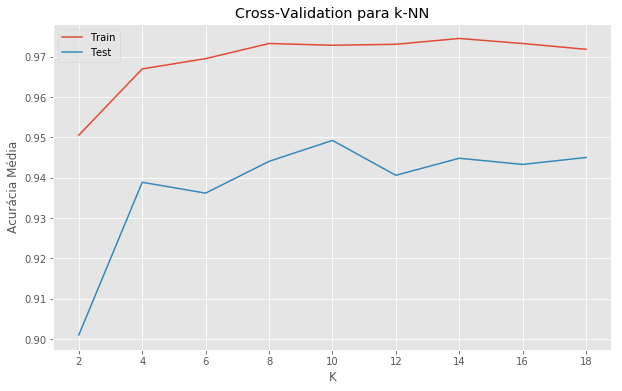

In [40]:
plt.figure(figsize=(10,6))
plt.xlabel('número de árvores')
plt.ylabel('Acurácia Média')
plt.title('Cross-Validation para Random Forest')
plt.plot(results_rf['acc_mean_train'], label='Train')
plt.plot(results_rf['acc_mean_test'], label='Test')
plt.legend()

In [41]:
# Reordenando para se encontrar o melhor resultado
results_rf = results_rf.sort_values(by=['acc_mean_test', 'acc_mean_train'], ascending=False)
results_rf = results_rf.sort_values(by=['Dif'], ascending=True) # Rodou-se esse chunck com essa linha comentada para comparação!

#Visualizando os 5 primeiros
results_rf.head()

,acc_mean_train,acc_mean_test,acc_sd_rain,acc_sd_test,Dif
10,0.972847,0.949251,0.002619,0.008977,0.023596
18,0.971838,0.945024,0.002991,0.010380,0.026814
4,0.966984,0.938869,0.001786,0.011601,0.028115
8,0.973280,0.944060,0.002291,0.014058,0.029220
14,0.974529,0.944828,0.003304,0.012751,0.029701


Observando o gráfico e a tabela ordenada a cima, podemos tirar algumas conclusões.

Notamos que o melhor resultado médio nos dados de teste aconteceu com 10 árvores de decisão. No entanto, é interessante notar que a diferença dos resultados entre este e o caso com 4 árvores, não é tão grande assim. Além disso, no caso em que n_estimators=4, diminui-se a variância com relação ao outro caso. Sendo asim, seria prudente dizer que o modelo mais indicado é aquele em que se utiliza 4 árvores de decisão.

Nota-se também que a escala do gráfico pode ser um fator de condução ao erro, uma vez que a diferença entre os dados de treino e de teste não é tão menor quanto parece para o modelo com 4 árvores.

### 3.6 Gradient Tree Boosting

Este modelo funciona com base em um ensemble de modelos de previsões mais fracos, geralmente árvores de decisão, de forma similar à que funciona os random forests. Seu diferencial está na permissão da escolha da função custo, ou seja, na regularização do modelo. A penalização devida a complexidade do modelo é a forma desse método atacar de frente o tipo de erro devido ao viés. No entanto, como de costume, diminui-se o viés, aumenta-se a variância.

Assim, ao utilizarmos árvores de decisões como os modelos mais fracos, temos um menor custo computacional, além de uma metodologia que de certa forma diminuia variância. Ou seja, tenta-se compensar o aumento da variância devido a regularização.

Por fim, Gradient Tree Boosting é o modelo que tenta atacar por todos os ângulos o problema do trade-off viés variância.

Aqui o parâmetro a ser variado na cross-validation será o número de iterações.

In [76]:
from sklearn.ensemble import GradientBoostingClassifier

In [77]:
X = df_n.iloc[:,1:]
y = df_n.iloc[:,0]

In [78]:
cv = KFold(n_splits=5, random_state=1, shuffle=False)
sizes = list(range(1, 100, 5))
acc_test_mean = []
acc_train_mean = []
acc_test_sd = []
acc_train_sd = []
for iterations in sizes:
    acc_test = []
    acc_train = []
    for train_index, test_index in cv.split(X):
        # Separando em treino e teste
        X_train, X_test, y_train, y_test = X.loc[train_index], X.loc[test_index], y.loc[train_index], y.loc[test_index]

        # Criando objeto para k-NN
        model_gb = GradientBoostingClassifier(n_estimators=iterations, subsample=1, max_depth=6, max_features=20)

        # Treinando o modelo
        model_gb.fit(X_train, y_train.values.ravel())

        # Fazendo previsões
        y_pred_test = model_gb.predict(X_test)
        y_pred_train = model_gb.predict(X_train)
        
        # Calculando a acurácia, precisão e recall
        acc_test.append(metrics.accuracy_score(y_test, y_pred_test))
        acc_train.append(metrics.accuracy_score(y_train, y_pred_train))

    # Calculando a média da acurácia
    acc_test_mean.append(np.array(acc_test).mean())
    acc_train_mean.append(np.array(acc_train).mean())
    acc_test_sd.append(np.array(acc_test).std())
    acc_train_sd.append(np.array(acc_train).std())

In [50]:
# Criando dataframes com os resultados
mean_test_gb = pd.DataFrame(acc_test_mean, index=sizes, columns=['acc_mean_test'])
mean_train_gb = pd.DataFrame(acc_train_mean, index=sizes, columns=['acc_mean_train'])
sd_test_gb = pd.DataFrame(acc_test_sd, index=sizes, columns=['acc_sd_test'])
sd_train_gb = pd.DataFrame(acc_train_sd, index=sizes, columns=['acc_sd_rain'])

In [51]:
# Concatena e cria um dataframe com os resultados
results_gb = pd.DataFrame(pd.concat([mean_train_gb, mean_test_gb,
                                      sd_train_gb, sd_test_gb], axis=1))

# Calculando as diferenças
results_gb['Dif'] = results_gb['acc_mean_train'] - results_gb['acc_mean_test']

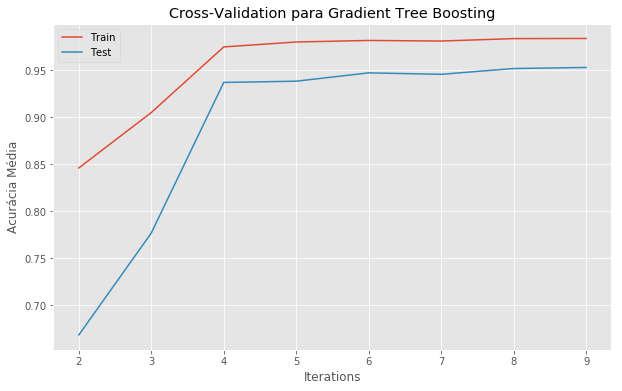

In [52]:
plt.figure(figsize=(10,6))
plt.xlabel('Iterations')
plt.ylabel('Acurácia Média')
plt.title('Cross-Validation para Gradient Tree Boosting')
plt.plot(results_gb['acc_mean_train'], label='Train')
plt.plot(results_gb['acc_mean_test'], label='Test')
plt.legend()

In [53]:
# Reordenando para se encontrar o melhor resultado
results_gb = results_gb.sort_values(by=['acc_mean_test', 'acc_mean_train'], ascending=False)
results_gb = results_gb.sort_values(by=['Dif'], ascending=True) # Rodou-se esse chunck com essa linha comentada para comparação!

#Visualizando os 10 primeiros
results_gb.head(10)

,acc_mean_train,acc_mean_test,acc_sd_rain,acc_sd_test,Dif
9,0.983708,0.952907,0.002423,0.009015,0.030802
8,0.983564,0.951754,0.002246,0.010636,0.031810
6,0.981594,0.947140,0.001751,0.010416,0.034453
7,0.980969,0.945604,0.002522,0.015083,0.035365
4,0.974721,0.936957,0.003893,0.020052,0.037764
5,0.979959,0.938301,0.002325,0.020327,0.041658
3,0.904978,0.776916,0.113038,0.268790,0.128063
2,0.846052,0.668548,0.140227,0.322530,0.177504


Aqui, tem-se um bom exemplo em que é possível observar que nem sempre o melhor erro no banco de teste (estimativa do erro esperado) está relacionado ao melhor modelo. Notamos que para 4 iterações o algoritmo já possui um desempenho muito próximo do que teria com 9. No entanto, a depender do pesquisador, pode-se optar pelo caso de 6 iterações. Essa seria uma escolha clara do pesquisador, visto que a diferença pode ser considerada significativa para uns e para outros não. No entanto, evidencia-se que o caso com menor erro esperado (9 iterações) não é o melhor modelo.

### 3.7 COMPARAÇÃO

#### Naive Bayes

In [54]:
# Separando em treino e teste
idx = list(df_n.index)                            # lista os indexes
np.random.shuffle(idx)                            # embaralha os index
train, test = df_n[:int(0.6*len(idx))], df_n[int(0.6*len(idx)):]              # seleciona os 60% e os 40%. (NORMALIZADO)

# Separando em y e X com normalização
train_x, train_y = train.iloc[:,1:], train['koi_disposition']
test_x, test_y = test.iloc[:,1:], test['koi_disposition']

In [55]:
from sklearn.naive_bayes import GaussianNB

# Criando um classificador gaussiano
model_nb = GaussianNB()

# Treinando o modelo
model_nb.fit(train_x, train_y)

# Predict Output
y_pred_test = model_nb.predict(test_x)
y_pred_train = model_nb.predict(train_x)

In [56]:
# Print da Matriz de confusão
print(confusion_matrix(test_y, y_pred_test))

[[1769  169]
 [  18  125]]


In [57]:
print(classification_report(test_y, y_pred_test))

             precision    recall  f1-score   support

          0       0.99      0.91      0.95      1938
          1       0.43      0.87      0.57       143

avg / total       0.95      0.91      0.92      2081



In [58]:
print('Acurácia Train:', metrics.accuracy_score(train_y, y_pred_train))
print('Acurácia Test:', metrics.accuracy_score(test_y, y_pred_test))

Acurácia Train: 0.938481256008
Acurácia Test: 0.910139356079


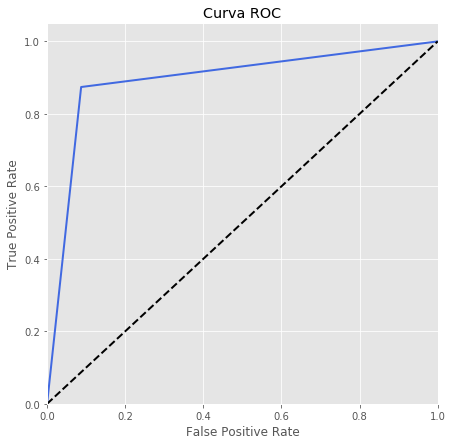

In [59]:
fpr, tpr, _ = metrics.roc_curve(test_y, y_pred_test)

plt.figure(figsize=(7, 7))
lw = 2
plt.plot(fpr, tpr, color='royalblue',lw=2)
plt.plot([0, 1], [0, 1], color='Black', lw=2, ls='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.show()

#### Decision Tree

In [60]:
# Separação do banco.
X = df.iloc[:,1:]
y = df.iloc[:,0]

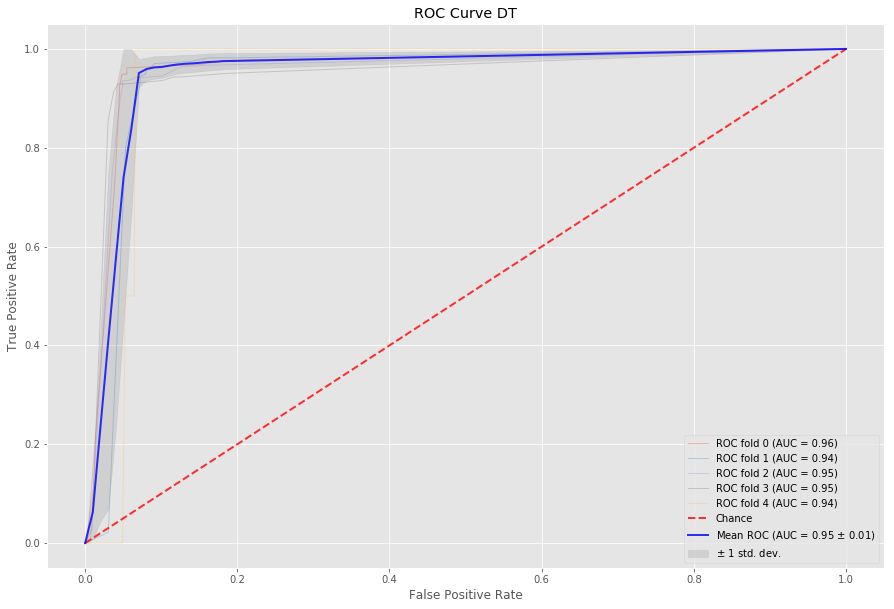

In [61]:
from scipy import interp
plt.figure(figsize=(15,10))
cv = KFold(n_splits=5, random_state=1, shuffle=False)
classifier = DecisionTreeClassifier(max_depth=6)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in cv.split(X):
    probas_ = classifier.fit(X.loc[train], y.loc[train]).predict_proba(X.loc[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = metrics.roc_curve(y.loc[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = metrics.auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve DT')
plt.legend(loc="lower right")
plt.show()

#### k-NN

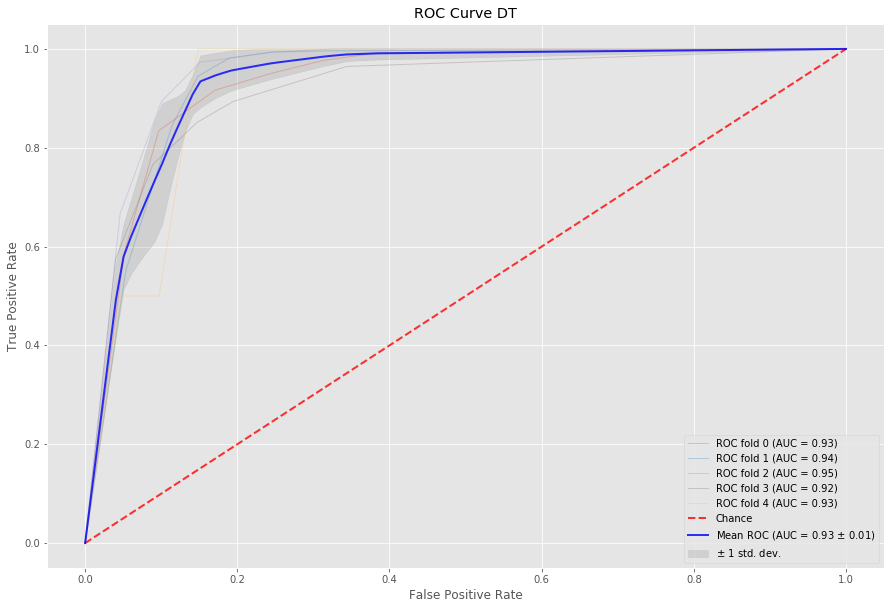

In [83]:
plt.figure(figsize=(15,10))
cv = KFold(n_splits=5, random_state=1, shuffle=False)
classifier = KNeighborsClassifier(n_neighbors=6)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in cv.split(X):
    probas_ = classifier.fit(X.loc[train], y.loc[train]).predict_proba(X.loc[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = metrics.roc_curve(y.loc[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = metrics.auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve DT')
plt.legend(loc="lower right")
plt.show()

#### Random Forest

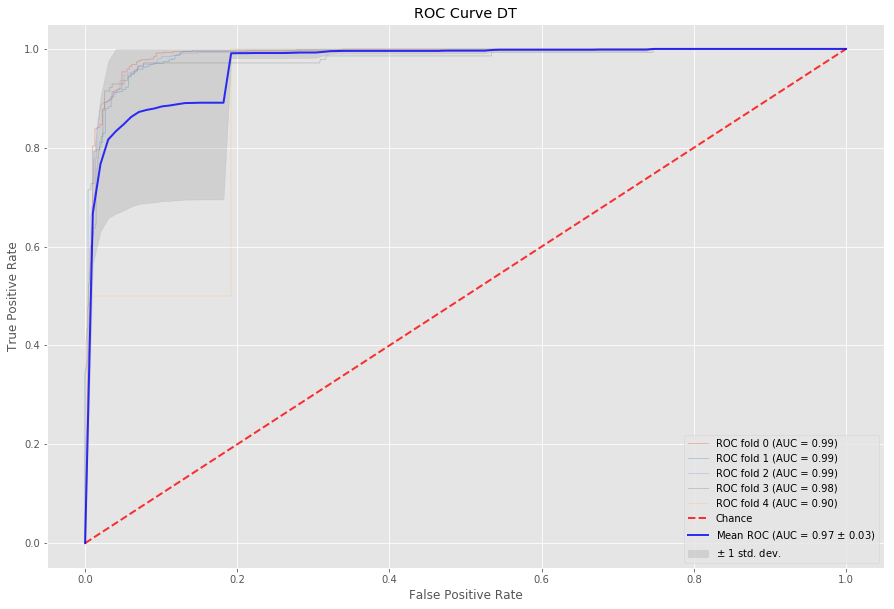

In [84]:
plt.figure(figsize=(15,10))
cv = KFold(n_splits=5, random_state=1, shuffle=False)
classifier = RandomForestClassifier(n_estimators=14, max_depth=6)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in cv.split(X):
    probas_ = classifier.fit(X.loc[train], y.loc[train]).predict_proba(X.loc[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = metrics.roc_curve(y.loc[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = metrics.auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve DT')
plt.legend(loc="lower right")
plt.show()

#### Gradient Tree Boosting

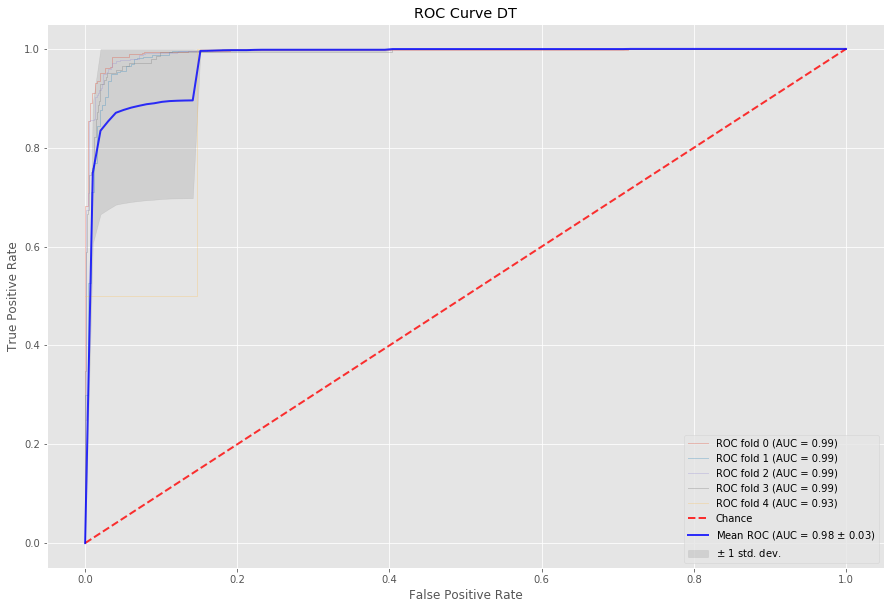

In [85]:
plt.figure(figsize=(15,10))
cv = KFold(n_splits=5, random_state=1, shuffle=False)
classifier = GradientBoostingClassifier(n_estimators=iterations, subsample=1, max_depth=6, max_features=20)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in cv.split(X):
    probas_ = classifier.fit(X.loc[train], y.loc[train]).predict_proba(X.loc[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = metrics.roc_curve(y.loc[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = metrics.auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve DT')
plt.legend(loc="lower right")
plt.show()

## Conclusões

Após a realização do trabalho e aplicação dos métodos, podeo observar que o poder dessas ferramentas de machine learning é muito alto. Para o caso em questão os modelos atingiram níveis de acerto a cima de 90%.

Dentre os modelos testados, o com melhor desempenho, com base na AUC, uma medida relacionada a acurácia foi o gradient tree bosting